# Legal Judgement Predictor - A classification task on BERT embeddings

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler

path_to_datasets = 'embeddings_datasets/legal-bert-base-uncased/'
create_dataset = False

## Preprocessing

In [2]:
class ECHRDataset(Dataset):
        def __init__(self, data, attention_mask, labels):
            self.data = data
            self.attention_mask = attention_mask
            self.labels = labels

        def __len__(self):
            return len(self.data)

        def __getitem__(self, idx):
            return self.data[idx], self.attention_mask[idx], self.labels[idx]

In [3]:
if create_dataset:
        
    # pad the data to be of the same shape
    def pad_data(data, max_len):
        padded_data = []
        attention_masks = []
        for i in range(len(data)):
            attention_masks.append([1] * data[i].shape[0] + [0] * (max_len - data[i].shape[0]))
            padded_data.append(F.pad(data[i], (0, 0, 0, max_len - data[i].shape[0])))
        #print(len(attention_masks))
        return torch.stack(padded_data), torch.tensor(attention_masks)

    # load data
    train = torch.load('embeddings/legal-bert-base-uncased/emb_tr_cpu.pkl')
    dev = torch.load('embeddings/legal-bert-base-uncased/emb_dev_cpu.pkl')
    test = torch.load('embeddings/legal-bert-base-uncased/emb_test_cpu.pkl')

    print('Train '+str(len(train)),'Dev '+str(len(dev)), 'Test '+str(len(test)))
    
    # concat dev to train series
    train = np.concatenate((train, dev))

    print('Train + Dev = '+str(len(train)))

    # load labels
    train_labels = pd.read_pickle('embeddings/legal-bert-base-uncased/train_labels.pkl')
    dev_labels = pd.read_pickle('embeddings/legal-bert-base-uncased/dev_labels.pkl')
    test_labels = pd.read_pickle('embeddings/legal-bert-base-uncased/test_labels.pkl')

    # concat dev labels to train labels
    train_labels = torch.tensor(np.concatenate((train_labels, dev_labels)))

    # pad the data
    max_len_train = max([x.shape[0] for x in train])
    max_len_test = max([x.shape[0] for x in test])
    train, train_attention_masks = pad_data(train, max_len_train)
    test, test_attention_masks = pad_data(test, max_len_test)

    # create the datasets
    train_dataset = ECHRDataset(train, train_attention_masks, train_labels)
    test_dataset = ECHRDataset(test, test_attention_masks, test_labels)

    print (train_dataset.data.device)

    # save the datasets
    if not os.path.exists(path_to_datasets):
        os.makedirs(path_to_datasets)
    torch.save(train_dataset, path_to_datasets+'train_dataset.pt')
    torch.save(test_dataset, path_to_datasets+'test_dataset.pt')


In [4]:
if not create_dataset:
    train_dataset = torch.load(path_to_datasets+'train_dataset.pt')
    test_dataset = torch.load(path_to_datasets+'test_dataset.pt')
    print(len(train_dataset))

8480


## Baseline

(8480, 768)


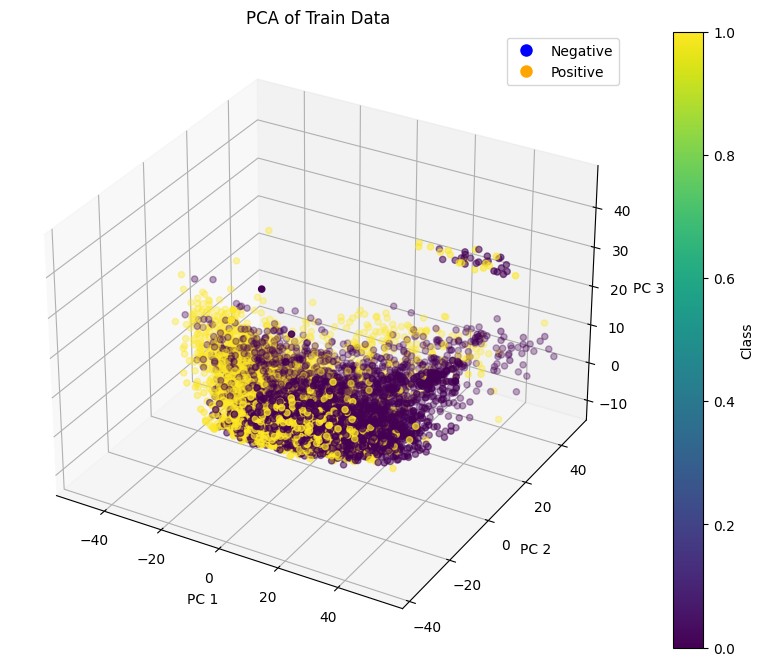

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Importing Axes3D for 3D plotting
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

scaler = StandardScaler()
mean_train = np.array([x.mean(0).numpy() for x in train_dataset.data])

print(mean_train.shape)

train_scaled = scaler.fit_transform(mean_train)

pca = PCA(n_components=3)
xpca = pca.fit_transform(train_scaled)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(xpca[:, 0], xpca[:, 1], xpca[:, 2], c=train_dataset.labels, cmap='viridis')

# Adding legend for positive and negative classes
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Negative'),
                    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10, label='Positive')],
           loc='upper right')

# Set labels and title
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
plt.title('PCA of Train Data')

# Add colorbar
plt.colorbar(scatter, label='Class')

plt.show()

In [6]:
# BASELINE on avg of chunks

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

# Assuming you have already defined and scaled mean_train and train_dataset.labels

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(train_scaled, train_dataset.labels, test_size=0.2, random_state=42)

# Initializing the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Training the classifier
rf_classifier.fit(X_train, y_train)

# Predicting on the test set
y_pred = rf_classifier.predict(X_test)

# Calculating metrics
f1 = f1_score(y_test, y_pred, average='weighted')
print(classification_report(y_test, y_pred))
print("Random Forest F1:", f1)


              precision    recall  f1-score   support

           0       0.83      0.80      0.81       826
           1       0.81      0.84      0.83       870

    accuracy                           0.82      1696
   macro avg       0.82      0.82      0.82      1696
weighted avg       0.82      0.82      0.82      1696

Random Forest F1: 0.8194487888494069


In [7]:
from sklearn.svm import SVC

# Initializing the SVM classifier
svm_classifier = SVC(kernel='linear', random_state=42)

# Training the classifier
svm_classifier.fit(X_train, y_train)

# Predicting on the test set
y_pred_svm = svm_classifier.predict(X_test)

# Calculating metrics
f1 = f1_score(y_test, y_pred_svm, average='weighted')
print(classification_report(y_test, y_pred_svm))
print("SVM F1:", f1)

              precision    recall  f1-score   support

           0       0.87      0.82      0.85       826
           1       0.84      0.89      0.86       870

    accuracy                           0.85      1696
   macro avg       0.86      0.85      0.85      1696
weighted avg       0.86      0.85      0.85      1696

SVM F1: 0.8541020575918331


In [9]:
from sklearn.neural_network import MLPClassifier

# Initializing the MLP classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100,), max_iter=200, random_state=42)

# Training the classifier
mlp_classifier.fit(X_train, y_train)

# Predicting on the test set
y_pred_mlp = mlp_classifier.predict(X_test)

# Calculating metrics
f1 = f1_score(y_test, y_pred_mlp, average='weighted')
print(classification_report(y_test, y_pred_mlp))
print("MLP F1:", f1)

              precision    recall  f1-score   support

           0       0.84      0.83      0.84       826
           1       0.84      0.85      0.85       870

    accuracy                           0.84      1696
   macro avg       0.84      0.84      0.84      1696
weighted avg       0.84      0.84      0.84      1696

MLP F1: 0.8407568932218789


## AttentionMLP Model

In [5]:
# check if windows or macos
if (torch.cuda.is_available()):
    print("Running on GPU")
    device = torch.device('cuda')
elif (torch.backends.mps.is_available()):
    print("Running on MPS")
    device = torch.device('mps')
else :
    print("Running on CPU")
    device = torch.device('cpu')

train_dataset.data = train_dataset.data.to(device)
train_dataset.labels = train_dataset.labels.to(device)
train_dataset.attention_mask = train_dataset.attention_mask.to(device)

test_dataset.data = test_dataset.data.to(device)
test_dataset.labels = test_dataset.labels.to(device)
test_dataset.attention_mask = test_dataset.attention_mask.to(device)

Running on MPS


In [6]:
class AttentionMLP(nn.Module):
    def __init__(self, input_dim, hidden_sizes, dropout=0, weight_decay=0.01):
        super(AttentionMLP, self).__init__()
        # vector for query attention
        self.selector = nn.parameter.Parameter(torch.randn(input_dim, 1))
        self.Value= nn.Linear(input_dim, input_dim, bias=False)
        self.Key = nn.Linear(input_dim, input_dim, bias=False)
        # mlp layers
        layers = []
        for i in range(len(hidden_sizes) - 1):
            layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i + 1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
        self.mlp = nn.Sequential(*layers)
        self.output = nn.Linear(hidden_sizes[-1], 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, attention_mask=None):
        # attention
        key = self.Key(x)

        value = self.Value(x)

        non_normalized_attention = torch.matmul(key, self.selector)
        if attention_mask is not None:
            attention_mask=attention_mask.unsqueeze(2)

            non_normalized_attention = non_normalized_attention.masked_fill(attention_mask == 0, -1e9)
        attention = F.softmax(non_normalized_attention, dim=1)
        # permute the attention to match the shape of the value
        attention = attention.permute(0, 2, 1)

        x = torch.matmul(attention, value)

        # mlp
        x = self.mlp(x)
        x = self.output(x)
        x = self.sigmoid(x)
        return x.flatten()


In [ ]:
from src.utils import k_fold_attention
model = AttentionMLP(768, [768,16])
model = model.to(device)
k_fold_attention ( model, 
                  criterion=nn.BCELoss(), 
                  optimizer=optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.001),
                  train_dataset= train_dataset, 
                  k_folds=3, 
                  epochs=30, 
                  batch_size=64 )

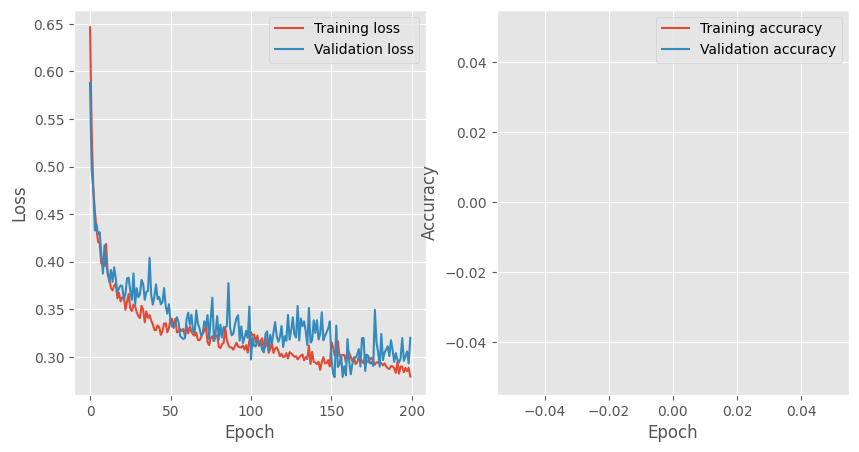

In [17]:
# print training and validation loss
plt.style.use('ggplot')

# plot two image by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(train_losses, label='Training loss')
ax[0].plot(val_losses, label='Validation loss')
ax[0].legend()
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].plot(val_accuracies, label='Validation accuracy')
ax[1].legend()
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
plt.show()

# RnnMLP

In [6]:
# TODO: add RELU layer

class RNNHead(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, hidden_dim_mlp, output_dim, dropout=0., bidirectional=False):
        super(RNNHead, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.rnn = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout, bidirectional=bidirectional)
        self.fc = nn.Linear(hidden_dim, hidden_dim_mlp)
        self.fc2 = nn.Linear(hidden_dim_mlp, output_dim)
        self.sigmoid = nn.Sigmoid()

    
    def forward(self, x, lengths):
        # pack the padded sequence
        x = nn.utils.rnn.pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        # forward pass through LSTM
        out, (h_n, c_n) = self.rnn(x)
        # unpack the packed sequence
        output= self.fc(h_n[-1])
        output = self.fc2(output)
        output=self.sigmoid(output)
        return output.flatten()

In [ ]:
from src.utils import k_fold_rnn
# create the model
model = RNNHead(768, 64, 2, 16, 1, dropout=0.1)
model = model.to(device)
k_fold_rnn(model, 
            criterion=nn.BCELoss(), 
            optimizer=optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-5), 
            train_dataset=train_dataset, 
            k_folds=3, 
            epochs=30, 
            batch_size=64)

In [ ]:
# print traianing and validation loss
plt.style.use('ggplot')

# plot two image by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(train_losses, label='Training loss')
ax[0].plot(val_losses, label='Validation loss')
ax[0].legend()
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].plot(val_accuracies, label='Validation accuracy')
ax[1].legend()
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
plt.show()

# Test the best model

In [ ]:
#load model 
from torch import load
model = load('models/attention-mlp/1709484443.4163241-0.3393.pth')
type(model)

In [ ]:
# test the best model
from sklearn.metrics import classification_report
with torch.no_grad():
    outputs = model(test_dataset.data, test_dataset.attention_mask)
    loss = criterion(outputs, test_dataset.labels.float())
    print(f'Test loss: {loss.item()}')
    print(classification_report(test_dataset.labels.cpu(), (outputs > 0.5).cpu()))
    # confusion matrix
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    import matplotlib.pyplot as plt
    cm = confusion_matrix(test_dataset.labels.cpu(), (outputs > 0.5).cpu())
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    